In [1]:
import pandas as pd
from func import cal_buoyancy
from sklearn.metrics import mean_squared_error
import glob
import os
import re
import traceback
from scipy.interpolate import interp1d
import datetime
import metpy.calc as mpcalc
from metpy.units import units
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
from scipy.stats import pearsonr
from pydoc import help
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
%matplotlib inline

In [2]:
# ERA5 information: specific humidity

q_path = '/data/rong4/Data/ERA5/3hourly/quvw_US/specific_humidity'

all_files = glob.glob(os.path.join(q_path, "era5.specific_humidity.*.nc"))

# Filter files for years 2001-2018 and months 5-9

filtered_files = [
    
    file for file in all_files 
    
    if 2001 <= int(os.path.basename(file).split(".")[2][:4]) <= 2018  
    
    and 5 <= int(os.path.basename(file).split(".")[2][4:]) <= 9       
]

all_q = xr.open_mfdataset(filtered_files, combine='by_coords')

all_q = all_q.sel(latitude=36.6, longitude=-97.5, method="nearest")

qdf = all_q.assign_coords(time=all_q.time - pd.Timedelta(hours=6))

qdf = qdf.sel(time=qdf.time[qdf.time.dt.hour == 12])

qdf['time'].shape

(2754,)

In [3]:
with open('shared_apes_list.pkl', 'rb') as f:
    
    shared_apes_list = pickle.load(f)
    
len(shared_apes_list)

147

In [4]:
with open('shared_nonapes_list.pkl', 'rb') as f:
    
    shared_nonapes_list = pickle.load(f)
    
len(shared_nonapes_list)

1578

In [5]:
# ARM information 

with open('soundings_fig5&6.pdkl','rb') as file:
    
    armdf = pickle.load(file)
     
# extracting only relevant columns for armdf, renaming for clarity

armdf = armdf[['blt','Blc','interp_temp','q_obs', 'interp_alt', 'APE']]

armdf = armdf.rename(columns={
    'blt': 'arm_blt',
    'Blc': 'arm_blc',
    'interp_temp': 'arm_interp_temp',
    'q_obs': 'arm_q_obs',
    'interp_alt': 'arm_interp_alt'
})

In [6]:
# ERA5 information: temperature, humidity, pressure, altitude

base_path = '/home/annierosen16/data/era5sgp/era5_ml_q_t_cf'

file_pattern = f"{base_path}/ERA5_*"

file_list = glob.glob(file_pattern)

all_era5 = xr.open_mfdataset(file_list, combine='by_coords', chunks={'time': 24})

era5_time_shift = all_era5.assign_coords(valid_time=all_era5.valid_time - pd.Timedelta(hours=6))

# Select the closest latitude and longitude to (36.6, -97.5)
era5 = era5_time_shift.sel(latitude=36.6, longitude=-97.5, method="nearest")

print(len(file_list))

2754


In [7]:
g = 9.80665 # m/s^2

cf_height = 315.0 # meters

era5time = era5['valid_time'].load().data

era5q = era5['q'].load().data * 1000 # units = g/kg

era5temp = era5['t'].load().data - 273.15 # units = Celsius 

era5pres = era5['pressure_level'].data # units = hPa

era5z = (era5['z'].load().data / g) - cf_height # units = m

In [8]:
# interpolation of pressure, temperature and specific humidity 

max_altitude = 14680  # meters

new_heights = np.arange(0, max_altitude + 20, 20)

num_times = era5time.shape[0]  

num_new_heights = len(new_heights)

q_interp = np.full((num_times, num_new_heights), np.nan)  # Interpolated q

temp_interp = np.full((num_times, num_new_heights), np.nan)  # Interpolated temp

pres_interp = np.full((num_times, num_new_heights), np.nan)  # Interpolated pressure

# Perform interpolation for each time step

for t in range(num_times):
    
    valid_mask = (
        ~np.isnan(era5z[t, :]) &
        ~np.isnan(era5q[t, :]) &
        ~np.isnan(era5temp[t, :]) &
        ~np.isnan(era5pres)
    )
    
    if np.sum(valid_mask) < 2:

        continue
    
    z_valid = era5z[t, valid_mask]
    
    q_valid = era5q[t, valid_mask]
    
    temp_valid = era5temp[t, valid_mask]
    
    pres_valid = era5pres[valid_mask] 
    
    # Interpolation for q
    q_interpolator = interp1d(z_valid, q_valid, kind='linear', bounds_error=False, fill_value=np.nan)
    
    q_interp[t, :] = q_interpolator(new_heights)
    
    # Interpolation for temperature
    temp_interpolator = interp1d(z_valid, temp_valid, kind='linear', bounds_error=False, fill_value=np.nan)
    
    temp_interp[t, :] = temp_interpolator(new_heights)
    
    # Interpolation for pressure
    pres_interpolator = interp1d(z_valid, pres_valid, kind='linear', bounds_error=False, fill_value=np.nan)
    
    pres_interp[t, :] = pres_interpolator(new_heights)


In [9]:
# defining era5 df for further analysis

era5df = pd.DataFrame({
    
    'time': era5time,  # Time array (1D)
    
    'altitude': [new_heights] * len(era5time),  # Same altitude array for all times
    
    'pres_interp': list(pres_interp),  # 2D array converted to a list of 1D arrays
    
    'q_interp': list(q_interp),  # 2D array converted to a list of 1D arrays
    
    'temp_interp': list(temp_interp)  # 2D array converted to a list of 1D arrays
})

In [10]:
#daily q_fit calculation, adds a column called q_fit to era5df

q_corr_era5df = era5df['q_interp'].apply(pd.Series)

# q_corr_era5df = q_corr_era5df.dropna()

new_cols = range(0, len(q_corr_era5df.columns) * 20, 20)

q_corr_era5df.columns = new_cols

bottom_1km = 51

near_surface_layer = q_corr_era5df.iloc[:, :bottom_1km].mean(axis=1)

lr = LinearRegression()

X_input = near_surface_layer.values

X_input = X_input.reshape(len(near_surface_layer),1)

#q_fit is the same as observed q in the bottom 2km

bottom_2km = 101

q_fit = q_corr_era5df.iloc[:, :bottom_2km].copy()

stats_list=[]

for i in q_corr_era5df.columns:
    
    if 4000 >= i > 2000:
        
        y_target = q_corr_era5df.loc[:,i].values
        
        y_target = y_target.reshape(len(y_target),1)
        
        model = lr.fit(X_input,y_target)
        
        y_model = model.predict(X_input)
        
        model_mean = np.mean(y_model)
        
        model_std = np.std(y_model)
        
        obs_mean = np.mean(y_target)
        
        obs_std = np.std(y_target)
        
        stats = (i, model_mean, obs_mean, model_std, obs_std) 
        
        stats_list.append(stats)
        
        q_fit['{}_fit'.format(i)] = y_model

era5df['q_fit']=""

for i in range(era5df.shape[0]):
    
    q_fit_i = q_fit.iloc[i,:]
    
    era5df['q_fit'][i] = q_fit_i

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
# segmenting only for the first 4km of data and ensure they are numpy arrays

era5df['q_interp'] = era5df['q_interp'].apply(lambda x: np.array(x[:201]))

era5df['q_fit'] = era5df['q_fit'].apply(lambda x: np.array(x[:201]))

era5df['temp_interp'] = era5df['temp_interp'].apply(lambda x: np.array(x[:201]))

era5df['pres_interp'] = era5df['pres_interp'].apply(lambda x: np.array(x[:201]))

era5df['altitude'] = era5df['altitude'].apply(lambda x: np.array(x[:201]))

In [12]:
%run /home/annierosen16/func.ipynb

era5df["Blt"]=""

era5df["Blc"]=""

errors = 0

g = 9.80665 # m/s^2

for index in range(era5df.shape[0]):

    row = era5df.iloc[index,:]

    alt = row['altitude']

    p = row['pres_interp']

    t = row['temp_interp']

    qlc = row['q_fit']

    qr = row['q_interp']

    b_qr = cal_buoyancy(t_profile = t,         
                            h_profile = qr,         
                            p_profile = p,        
                            alt_profile = alt,
                            entrain_opt = 2
                            )

    b_qlc = cal_buoyancy(t_profile = t,         
                        h_profile = qlc,         
                        p_profile = p,        
                        alt_profile = alt,
                        entrain_opt = 2
                        )

    pprof_qr = (b_qr.tp)*units.degK

    pprof_qlc = (b_qlc.tp)*units.degK

    t = row['temp_interp']*units.degC

    t = t.to(units.degK)

    y_qr = pprof_qr - t

    y_qlc = pprof_qlc - t
    
#     buoyancy_r_profile = ((pprof_qr - t)/t)*g
    
#     buoyancy_lc_profile = ((pprof_qlc - t)/t)*g

    pres_100 = p[0]-100

    pres_300 = p[0]-300

    pres_mask = (p >= pres_300) & (p <= pres_100)

    altmask = (alt >= 2000) & (alt <= 4000)

#         x_clipped = p[pres_mask]

#         y_clipped_qr = y_qr[pres_mask]

#         y_clipped_qlc = y_qlc[pres_mask]

    x_clipped = p[altmask]

    y_clipped_qr = y_qr[altmask]

    y_clipped_qlc = y_qlc[altmask]

    #multiply by kelvin here? check units

    buoyancy_r = (mpconsts.Rd*(np.trapz(y_clipped_qr[::-1], np.log(x_clipped[::-1])))).to(units('J/kg'))

    buoyancy_lc = (mpconsts.Rd*(np.trapz(y_clipped_qlc[::-1], np.log(x_clipped[::-1])))).to(units('J/kg'))

    blt = buoyancy_r - buoyancy_lc

    era5df.loc[index, "Blt"] = blt.magnitude
    
    era5df.loc[index, "Blc"] = buoyancy_lc.magnitude
    
#     era5df.loc[index, "br_profile"] = buoyancy_r_profile.magnitude.tolist()
    
#     era5df.loc[index, "blc_profile"] = buoyancy_lc_profile.magnitude

    print(index, blt.magnitude, buoyancy_lc.magnitude, buoyancy_r.magnitude)
    
#     except Exception as e:
        
#         errors+=1
        
#         print(f"Error at index {index}: {str(e)}")

0 -12.15827126272751 -115.2009373068099 -127.35920856953742
1 -13.468921783905557 -388.3320276764449 -401.80094946035047
2 4.42140590663422 -57.48215816356465 -53.06075225693043
3 5.434444026146199 -17.27681076301313 -11.842366736866932
4 -9.86026252753149 -88.37099063762967 -98.23125316516116
5 -9.846346400287198 -13.00944784781939 -22.855794248106587
6 4.6353451398216805 -165.82343919083252 -161.18809405101084
7 -4.484013404809303 -177.82381463271687 -182.30782803752618
8 -9.230052328016214 -64.61157067111604 -73.84162299913226
9 8.470765824143804 -60.63259976216068 -52.161833938016876
10 4.047505561705435 -87.06720035241165 -83.01969479070621
11 -4.067779811959184 -177.36962573285828 -181.43740554481747
12 -9.305827806154468 -154.62609382309182 -163.9319216292463
13 -4.091512399445946 -143.4999879355982 -147.59150033504415
14 6.4098965391247305 -162.25134577110356 -155.84144923197883
15 -8.242924469832559 -220.16401038692337 -228.40693485675592
16 0.7840531531742272 -77.937784798559

135 -11.079541879307214 -411.4760102678119 -422.5555521471191
136 -11.132162619106367 -249.1226032334645 -260.25476585257087
137 15.154040696593711 -136.39069137713855 -121.23665068054484
138 2.605467874421663 -200.70486891763179 -198.09940104321012
139 10.913668598125852 -106.30033673609516 -95.38666813796931
140 -11.317011228686624 -271.80608454324533 -283.12309577193196
141 -7.733036720259861 -306.06320756181253 -313.7962442820724
142 5.562734253741667 -143.01069751321515 -137.44796325947348
143 -13.959894045125594 -196.6475388644615 -210.6074329095871
144 -15.587770862833949 -118.79531652871508 -134.38308739154903
145 -4.54026117112295 -370.012170343005 -374.55243151412793
146 -15.057725447081793 -669.3672591040284 -684.4249845511102
147 -10.372235292375876 -639.1928537208573 -649.5650890132332
148 10.755656435172 -439.9951128455091 -429.2394564103371
149 -3.5406158925683826 -493.9193552159584 -497.45997110852676
150 5.795280377194672 -382.9010720624167 -377.105791685222
151 -14.48

268 15.197691627376287 -292.1367475349749 -276.93905590759863
269 -13.13286341404023 -281.05492381141784 -294.18778722545807
270 -10.106565582193525 -273.1107397180918 -283.2173053002853
271 -0.648352317475485 -363.02934478406894 -363.6776971015444
272 0.013765809238861948 -247.6250308528906 -247.61126504365174
273 2.5633984468272786 -134.5188305674478 -131.95543212062051
274 0.9883550796902796 -260.1460606990144 -259.15770561932413
275 6.1949708855694325 -194.85566097933247 -188.66069009376304
276 8.371465694679316 -106.83718259192369 -98.46571689724438
277 5.819547409607651 -252.78943638756235 -246.9698889779547
278 2.375943134851866 -204.56836214368633 -202.19241900883446
279 -2.1447087474544446 -159.91216134584377 -162.05687009329822
280 0.5606399428203872 -150.08112087002658 -149.5204809272062
281 1.1098788041470726 -83.05833242287017 -81.9484536187231
282 -2.7846159206679033 -177.97606582111675 -180.76068174178465
283 10.13748059714743 -181.76046890064674 -171.6229883034993
284 1

401 6.233698579346935 -311.67336465313076 -305.4396660737838
402 -7.351004234928581 -192.5142034673362 -199.86520770226477
403 5.472965757683738 -212.9485518404152 -207.47558608273147
404 7.019536076816195 -244.50596265360457 -237.48642657678838
405 18.8578790909541 -344.3787393854702 -325.5208602945161
406 0.9304152643482553 -234.81812413967043 -233.88770887532218
407 11.709495303744873 -110.0869294524009 -98.37743414865602
408 1.6779832819316596 -89.20549772875313 -87.52751444682147
409 3.438577297069344 -112.41819343104802 -108.97961613397868
410 4.754553981120665 -143.83965236086337 -139.0850983797427
411 6.581227263892941 -195.57194329974214 -188.9907160358492
412 4.302445234072422 -275.1133107470295 -270.8108655129571
413 1.2154963109096002 -271.56033828817453 -270.34484197726493
414 -1.7645977099938932 -237.3198702309667 -239.0844679409606
415 -0.46448339049865695 -216.28844873618624 -216.7529321266849
416 2.251544119611708 -215.17352253201102 -212.9219784123993
417 -0.159676943

534 7.878001019935681 -160.147638031207 -152.26963701127133
535 9.159400277088025 -120.22855615821354 -111.06915588112551
536 0.31191270870220933 -252.5903417287511 -252.2784290200489
537 -3.4956414648062264 -260.5490233134339 -264.04466477824013
538 8.268198427073173 -200.93678762766558 -192.6685892005924
539 -0.04171943992190563 -228.4893560635948 -228.53107550351672
540 -4.607812471785621 -272.1890335496809 -276.79684602146654
541 -18.02529078251166 -281.3319312173004 -299.35722199981205
542 -11.280162454754276 -137.5706337974461 -148.85079625220038
543 14.63386574011571 -297.1011183806014 -282.4672526404857
544 11.173627636694277 -381.64130090871805 -370.4676732720238
545 -15.243948526472309 -421.43577714076434 -436.67972566723665
546 -17.81915824558058 -427.73041325468694 -445.5495715002675
547 21.311956217618956 -188.05623390568005 -166.7442776880611
548 16.62797022406778 -274.95222934945673 -258.32425912538895
549 -7.474128613927746 -369.7016509018868 -377.17577951581455
550 -7.

666 -1.9582430332206968 -212.15500957963405 -214.11325261285475
667 0.4020021513206018 -158.85586603255885 -158.45386388123825
668 2.2421093290083576 -116.64267094452352 -114.40056161551516
669 6.783636122775874 -142.96989090247183 -136.18625477969596
670 -0.4040787914635757 -285.87453816598673 -286.2786169574503
671 -5.389021597354542 -330.92503636720346 -336.314057964558
672 2.794352999440605 -244.90875888855183 -242.11440588911123
673 -10.839015374856473 -226.0180792503104 -236.85709462516687
674 -2.573551966574371 -352.8100299092786 -355.383581875853
675 -4.515579993204142 -246.89349671216218 -251.40907670536632
676 -10.164740217209726 -229.6050217198728 -239.76976193708254
677 2.624824954711684 -39.4822777759458 -36.85745282123412
678 -4.444250101273951 -159.9498371384042 -164.39408723967816
679 -6.5685808447589125 -248.77487606642578 -255.3434569111847
680 6.177594329628789 -222.34940747391562 -216.17181314428683
681 1.9456395016137265 -226.52412239148168 -224.57848288986796
682 

800 -10.27623339037575 -343.1537321704068 -353.42996556078253
801 -9.892529898021792 -226.300451616324 -236.1929815143458
802 -10.183106289755983 -277.10790754991626 -287.29101383967225
803 1.988029635992973 -338.45420165616525 -336.4661720201723
804 -1.204596330779168 -308.92894538142144 -310.1335417122006
805 2.736552699468575 -141.78763822337163 -139.05108552390305
806 5.33630449951778 -312.681004955505 -307.3447004559872
807 3.70743621007216 -264.5417772352926 -260.83434102522045
808 -2.114134122283872 -348.63641546703695 -350.7505495893208
809 -9.581831518099875 -425.2610682729718 -434.84289979107166
810 -8.177321485748053 -530.6342814493994 -538.8116029351474
811 -3.0453236321797306 -232.65706077710388 -235.7023844092836
812 -19.135088562245528 -142.61172968206526 -161.7468182443108
813 1.8931427609554135 -286.3907454255683 -284.4976026646129
814 -5.3821901570419755 -262.104701839817 -267.48689199685896
815 -4.712935466164822 -418.8083024578395 -423.5212379240043
816 -16.88051075

933 -11.6939941888117 -447.77547939859306 -459.46947358740476
934 7.2736931914488 -134.6172499818014 -127.3435567903526
935 2.983384316360798 -136.60336045045165 -133.61997613409085
936 8.263462719459795 -143.58214846070632 -135.31868574124653
937 5.264883563940558 -93.02502118571475 -87.76013762177419
938 11.2495352934761 -113.9240504142018 -102.6745151207257
939 -3.7973625144353207 -224.15738226035285 -227.95474477478817
940 -13.927651084465111 -181.92017651018568 -195.8478275946508
941 3.1888093603303673 -384.36328619255426 -381.1744768322239
942 8.43060443014744 -217.6225154943178 -209.19191106417037
943 8.106762673214874 -74.043628880636 -65.93686620742113
944 8.963036130858384 -94.39069478449754 -85.42765865363916
945 3.0006862656260154 -64.31482775628055 -61.314141490654535
946 3.96884484101345 -89.26566897392121 -85.29682413290776
947 3.886597377995912 -206.98041379082053 -203.09381641282462
948 -11.641412289123707 -192.5255910330147 -204.1670033221384
949 -0.15824307220870537 

1065 4.335537741299731 -436.0432381516999 -431.70770041040015
1066 -6.1633332400875815 -346.8084215233755 -352.9717547634631
1067 -14.174605224145324 -87.55857030003808 -101.73317552418341
1068 6.547988756348246 -193.85843422401672 -187.31044546766847
1069 -4.054364546070701 -406.5107561383102 -410.56512068438093
1070 4.057336660012538 -136.19310768912473 -132.1357710291122
1071 -5.7072323033058865 -158.6996269435533 -164.4068592468592
1072 -2.1229542193086743 31.648142469164824 29.52518824985615
1073 -8.070612923501471 -511.0948037241428 -519.1654166476443
1074 -0.19701245262376688 -327.05467686219873 -327.2516893148225
1075 -3.41220153693061 -161.9181255921608 -165.33032712909142
1076 1.2197909771905415 -194.41471940463515 -193.1949284274446
1077 7.8766385600044515 -51.04039325365919 -43.16375469365474
1078 -12.787741906996985 -318.72400768042087 -331.51174958741785
1079 -18.203200543909816 -287.16300664905435 -305.36620719296417
1080 -17.432238074325454 -133.07862098616147 -150.5108

1196 20.231374235386056 -354.9224589829159 -334.6910847475298
1197 -1.7703545421178433 -297.2517654135945 -299.02211995571236
1198 31.546972827877937 -420.1716677777608 -388.62469494988284
1199 14.760863995116779 -319.7726114680736 -305.0117474729568
1200 2.7571670245047244 -342.9204954885507 -340.163328464046
1201 -1.7045736809589869 -87.92261532022748 -89.62718900118647
1202 10.647258191306491 -416.7962403621106 -406.1489821708041
1203 -0.11251759561156405 -240.37424536377873 -240.4867629593903
1204 14.801878128088688 -121.71290812422235 -106.91102999613366
1205 12.762048345631442 -111.44281050052302 -98.68076215489158
1206 19.190122662176492 -274.07894459431947 -254.88882193214297
1207 1.8262384496563868 -476.21161413707495 -474.38537568741856
1208 -11.395117432801499 -496.8316563305437 -508.2267737633452
1209 -5.719606907658317 -535.9654109518888 -541.6850178595471
1210 -6.353663902886865 -497.46975906688516 -503.823422969772
1211 -12.065625668969403 -344.0068199088991 -356.0724455

1327 -9.295325265295872 -247.03440950534966 -256.32973477064553
1328 -11.198019092758386 -299.4440835446031 -310.64210263736146
1329 5.455453236743097 -178.75651528554306 -173.30106204879996
1330 17.713702382400584 -148.57338499757444 -130.85968261517385
1331 -2.286422214933225 -302.97617570800156 -305.2625979229348
1332 12.646887442439123 -234.2546303504908 -221.60774290805168
1333 11.965183772295063 -257.69421601882584 -245.72903224653078
1334 1.264938607058454 -112.30324910359955 -111.0383104965411
1335 2.8113560480271076 -305.6376323191822 -302.8262762711551
1336 2.315836839961662 -362.7284226524215 -360.41258581245984
1337 19.240360226724306 -451.51222556512477 -432.27186533840046
1338 19.402852912850904 -411.26116025954104 -391.85830734669014
1339 8.095902432759488 -255.3137227881148 -247.21782035535531
1340 4.830304927042391 -181.94521299125992 -177.11490806421753
1341 -7.580749866812056 -137.62286760935868 -145.20361747617073
1342 0.2758904857060429 -175.97774668954463 -175.701

1457 -10.714673280495191 -238.043627211154 -248.75830049164918
1458 14.926883837322322 -185.5781444082785 -170.65126057095617
1459 5.521961910601334 -232.70043767051322 -227.1784757599119
1460 10.037374607335408 -165.38549866006136 -155.34812405272595
1461 16.544544963625455 -99.90586857498091 -83.36132361135546
1462 13.587659939086464 -109.34758889018184 -95.75992895109538
1463 4.620359706985553 -46.900873201936264 -42.28051349495071
1464 6.403205326232012 -156.8478735826014 -150.4446682563694
1465 4.233729614047917 -97.1319092171959 -92.89817960314798
1466 13.30697282052813 -84.61269265585858 -71.30571983533045
1467 5.970695711008091 -287.0818623299935 -281.1111666189854
1468 7.5150528349531385 -189.90993615748886 -182.39488332253572
1469 9.717086365977906 -170.7105928861058 -160.99350652012788
1470 1.8072411219455944 -239.77246450210012 -237.96522338015453
1471 -3.510300185168319 -260.9921336098997 -264.50243379506804
1472 5.606233405077262 -211.74401845633886 -206.1377850512616
147

1588 -10.342564281244108 -307.0378865674892 -317.3804508487333
1589 0.8524978301980468 -280.5738596187315 -279.72136178853344
1590 1.4144276704090828 -200.97864323004177 -199.5642155596327
1591 2.293170172293401 -161.2930060335733 -158.9998358612799
1592 7.331338289165387 -74.54391343161402 -67.21257514244863
1593 3.5204050365839805 -184.85224047088212 -181.33183543429814
1594 11.451630257848194 -170.93686921266288 -159.4852389548147
1595 -2.4045658707069038 -136.08496938947553 -138.48953526018244
1596 3.6509445107074043 -210.60032580194633 -206.94938129123892
1597 6.793639875264603 -328.25110589482836 -321.45746601956375
1598 -6.124799856013283 -365.8000953631994 -371.92489521921266
1599 -0.5258800066529261 -322.69131215965774 -323.21719216631067
1600 3.480414015413473 -129.1629049259425 -125.68249091052904
1601 5.272895941109454 -182.10985242421592 -176.83695648310646
1602 11.3181127516537 -115.64034460242418 -104.32223185077048
1603 12.679084254334924 -171.43769616909378 -158.758611

1719 16.467388584111433 -176.7007597245138 -160.23337114040237
1720 -3.3521848635910487 -270.6152806234382 -273.96746548702924
1721 -9.459633737801369 -386.18575866645426 -395.64539240425563
1722 -6.837946437673793 -388.02863352738046 -394.86657996505426
1723 -21.71979936435457 -467.9544338794369 -489.6742332437915
1724 -1.9723355719377764 -409.42630886614745 -411.3986444380852
1725 -9.556981853867853 -328.4560532294124 -338.0130350832803
1726 10.517000240718545 -245.21882254555035 -234.7018223048318
1727 14.211756862436062 -170.03084698880312 -155.81909012636706
1728 -11.695954304118175 -247.49903811673033 -259.1949924208485
1729 -6.419479020203937 -175.4341755917848 -181.85365461198873
1730 5.016856885446799 -158.0216483594505 -153.0047914740037
1731 -6.968899549063394 -324.4062165026632 -331.3751160517266
1732 -14.518754580275356 -363.468960111047 -377.98771469132237
1733 -3.1783497971871952 -339.5213962434109 -342.6997460405981
1734 -5.540038962759866 -359.11393468165414 -364.65397

1850 -4.740807294249379 -30.80577862699083 -35.54658592124021
1851 4.928416578457757 -229.2662746937415 -224.33785811528375
1852 1.0238653201249122 -377.7552810592732 -376.7314157391483
1853 -14.055211020142735 -262.5776617061578 -276.63287272630055
1854 -24.80443288124843 -159.0084534483777 -183.81288632962614
1855 -10.422043294891623 -59.898785091197794 -70.32082838608942
1856 4.024784045209856 -261.7573574827275 -257.73257343751766
1857 0.8368304664584798 -234.42989931649538 -233.5930688500369
1858 6.0671954750442865 -325.83511436282896 -319.7679188877847
1859 6.9474633047608165 -167.7112911829627 -160.76382787820188
1860 5.944961137187676 -160.36774139371656 -154.42278025652888
1861 4.207828449333533 -192.9163026667921 -188.70847421745856
1862 -8.334864298047535 -307.71282593554383 -316.04769023359137
1863 -9.815769333460338 -244.11751970567084 -253.93328903913118
1864 7.705399507017262 -178.13327408963303 -170.42787458261577
1865 -15.232160813257345 -37.94430980406889 -53.17647061

1981 -16.077551066400076 -444.3619672946023 -460.4395183610024
1982 -9.068154947508958 -456.3909638519426 -465.4591187994516
1983 -6.686657532468075 -479.3539624512461 -486.0406199837142
1984 2.929229694595506 -284.4946557296111 -281.5654260350156
1985 -20.017665042730073 -392.4513233299493 -412.46898837267935
1986 10.147907667265486 -658.4108800157364 -648.262972348471
1987 -11.025454729796138 -624.5617025564196 -635.5871572862158
1988 -9.212024171716848 -578.8035622944012 -588.0155864661181
1989 2.175116186674515 48.81855253121575 50.993668717890266
1990 -2.743085921135588 -140.6022675588522 -143.34535347998778
1991 6.347295884107268 -131.8057281167705 -125.45843223266323
1992 0.2126196542721175 -151.6747037514976 -151.46208409722547
1993 -0.10806608579514432 -286.96962818945644 -287.0776942752516
1994 0.45575365594413597 -123.28442355503475 -122.82866989909061
1995 -1.3217731251320401 -129.8912739265284 -131.21304705166045
1996 -6.857620004013565 -27.84532637020202 -34.7029463742155

2112 -3.066850487294687 -346.01543738028585 -349.08228786758053
2113 0.19405392018560974 -252.65552349617843 -252.46146957599282
2114 -1.7223936500487866 -233.418287260032 -235.1406809100808
2115 0.15449102149256078 -241.9931088336435 -241.83861781215094
2116 6.576093377444039 -113.73007580609695 -107.15398242865291
2117 25.163574336275985 -419.7263200504608 -394.5627457141848
2118 0.3557578577267577 -441.4650385525016 -441.10928069477484
2119 -13.359512791260556 -303.48065468814633 -316.8401674794069
2120 10.470531161010882 -206.061056620446 -195.59052545943513
2121 14.36307911344619 -414.7399322848316 -400.3768531713854
2122 -9.578250420270706 -499.01004378668927 -508.58829420696
2123 31.370452260952675 -591.1964984752033 -559.8260462142506
2124 9.18443524414522 -789.9329138336618 -780.7484785895166
2125 11.546722922055892 -414.78680249990424 -403.24007957784835
2126 13.296616111404035 -160.01401029792646 -146.71739418652243
2127 3.9979378506511125 -304.4759878462237 -300.47804999557

2244 2.408600532161529 -271.62134766439783 -269.2127471322363
2245 19.848310786421905 -413.97912648794164 -394.13081570151974
2246 29.480521220602952 -392.443501714019 -362.96298049341607
2247 9.145562913100719 -277.283485366635 -268.13792245353426
2248 -8.158026450511272 -363.11879230447505 -371.2768187549863
2249 -7.106286912630139 -300.6606074168328 -307.76689432946296
2250 -0.5011553882081472 -125.75675484207459 -126.25791023028273
2251 12.564846602631889 -184.5168279047752 -171.9519813021433
2252 8.258560811334064 -429.52070583574937 -421.2621450244153
2253 -8.038047601558503 -437.92874939645293 -445.96679699801143
2254 -2.363639777459042 -211.76614095543582 -214.12978073289486
2255 1.2839289370959932 -194.73536202838696 -193.45143309129097
2256 42.8389538461829 -666.6284164972636 -623.7894626510807
2257 31.737406872908423 -554.9770066258645 -523.2395997529561
2258 24.181880631419517 -425.0104335771167 -400.8285529456972
2259 -16.035692037750835 -180.23833453751257 -196.2740265752

2375 8.248755907637928 -205.34248158765732 -197.0937256800194
2376 1.209591681602035 -237.97906954436374 -236.7694778627617
2377 1.8902048141704881 -251.56315113127928 -249.6729463171088
2378 -6.708479900576549 -284.24866805208455 -290.9571479526611
2379 2.291807462324755 -180.10151313097688 -177.80970566865213
2380 10.85368370340015 -180.6519867160308 -169.79830301263064
2381 7.167587366275086 -134.0849934121603 -126.9174060458852
2382 -6.971391216343164 -142.4278542774684 -149.39924549381158
2383 -3.356878445625199 -157.05690915914062 -160.41378760476582
2384 -8.089921623535076 -270.0407274930934 -278.1306491166285
2385 5.165607967466514 -166.07417825664947 -160.90857028918296
2386 9.147574537483706 -149.7176042563185 -140.5700297188348
2387 9.828065210062192 -155.96135935180274 -146.13329414174055
2388 12.815332385881561 -177.81685301080475 -165.0015206249232
2389 4.296543876349972 -154.09393672300345 -149.79739284665348
2390 14.055504962086445 -217.67174537576824 -203.6162404136818

2505 -0.07004523650731187 -71.05732531006753 -71.12737054657484
2506 -3.6887434159731356 -336.47706452137913 -340.16580793735227
2507 -6.942728423878748 -362.20559929950804 -369.1483277233868
2508 -3.4325185602563693 -260.46721993844517 -263.89973849870154
2509 -10.185785159822501 -293.5599284427345 -303.745713602557
2510 -1.9810179560198833 -83.40699438215641 -85.3880123381763
2511 -12.514926647555058 -259.94624972784453 -272.4611763753996
2512 3.00003020533444 -196.80443137350693 -193.8044011681725
2513 -0.41957296750112505 -217.95419655258166 -218.3737695200828
2514 -11.368996210747014 -245.4660593591404 -256.8350555698874
2515 -0.12690553676509353 -167.94286018593104 -168.06976572269613
2516 5.05482569450669 -269.607175195928 -264.5523495014213
2517 -3.572062810487182 -117.45524495674623 -121.02730776723341
2518 -16.64911433600605 -236.91400494835383 -253.56311928435989
2519 9.55663533269589 -201.33840245099708 -191.7817671183012
2520 -1.9888731892894782 -195.8542448315214 -197.843

2636 -9.169633030794017 -165.32624136747478 -174.4958743982688
2637 -18.134294649077503 -203.51465490399977 -221.64894955307727
2638 0.6010735959084741 -394.9573272475833 -394.3562536516748
2639 9.293888230456133 -228.02623425136866 -218.73234602091253
2640 0.5774902774367945 -165.20181525978984 -164.62432498235304
2641 -6.988256360481586 -149.25299346020273 -156.24124982068432
2642 6.490468222551954 -236.92669446322762 -230.43622624067567
2643 -1.985537640763539 -266.20145270201334 -268.1869903427769
2644 -6.579310606512365 -139.51024764844357 -146.08955825495593
2645 -4.3123324395154725 -245.39371617922987 -249.70604861874534
2646 4.378028654840023 -163.92055170269052 -159.5425230478505
2647 2.943276973141849 -218.07086149946204 -215.1275845263202
2648 4.3208553808189265 -235.28755967228471 -230.9667042914658
2649 2.8987106990894063 -147.04649096805454 -144.14778026896514
2650 8.268135906594665 -238.8400234286283 -230.57188752203365
2651 -0.7872121894019415 -277.44138264953017 -278.2

In [13]:
# moving time (timestamps) column into just dates along the index, to compare with arm 

era5df['time'] = pd.to_datetime(era5df['time'])

era5df.set_index(era5df['time'].dt.date, inplace=True)

era5df.drop(columns='time', inplace=True)

In [14]:
# extracting only relevant columns for era5df, for comparison with armdf and renaming for clarify

era5df = era5df[['Blt','Blc','altitude','q_interp','temp_interp','pres_interp']]

era5df = era5df.rename(columns={
    'Blt': 'era5_blt',
    'Blc': 'era5_blc',
    'temp_interp': 'era5_interp_temp',
    'q_interp': 'era5_q_obs',
    'altitude': 'era5_interp_alt',
    'pres_interp': 'era5_interp_pres'
})

In [15]:
# dumping to combine with APE information -> to calculate advection 

with open('era5df.pdkl', 'wb') as f:
    
    pickle.dump(era5df, f)

In [16]:
# verification that ERA5 buoyancy calculation for full domain is same as what i computed here

with open('all_blc.pkl', 'rb') as file:
    
    all_blc = pickle.load(file)
    
with open('all_blt.pkl', 'rb') as file:
    
    all_blt = pickle.load(file)
    

diff_blc = all_blc - era5df['era5_blc'].values

diff_blt = all_blt - era5df['era5_blt'].values

# Calculate RMSE for each
rmse_blc = np.sqrt(np.mean(diff_blc**2))
rmse_blt = np.sqrt(np.mean(diff_blt**2))

# Normalize by the range (max - min) of the reference array
range_blc = np.max(era5df['era5_blc'].values) - np.min(era5df['era5_blc'].values)

range_blt = np.max(era5df['era5_blt'].values) - np.min(era5df['era5_blt'].values)

nrmse_blc = rmse_blc / range_blc

nrmse_blt = rmse_blt / range_blt

print("NRMSE for blc (using range):", nrmse_blc)

print("NRMSE for blt (using range):", nrmse_blt)

corr_blc, _ = pearsonr(all_blc, era5df['era5_blc'].values)

corr_blt, _ = pearsonr(all_blt, era5df['era5_blt'].values)

print("Correlation for blc:", corr_blc)

print("Correlation for blt:", corr_blt)

NRMSE for blc (using range): 0.025895120165205145
NRMSE for blt (using range): 0.046273325376753265
Correlation for blc: 0.9904147922951851
Correlation for blt: 0.9953466859749174


In [17]:
# joining arm & era5 atmospheric information

result = armdf.join(era5df, how='inner')

# these files with blc > 300 are not physically realistic 

result_clean = result[result['arm_blc'] <= 300]

# keeping only the dates which have both been labeled as an APE

shared_apes_list = pd.to_datetime(shared_apes_list)

shared_nonapes_list = pd.to_datetime(shared_nonapes_list)

# now filter the 'result' DataFrame based on the index matching the dates in 'shared_apes_list'

shared_apes_result = result_clean[result_clean.index.isin(np.array(shared_apes_list))]

shared_nonapes_result = result_clean[result_clean.index.isin(np.array(shared_nonapes_list))]

shared_apes_result.shape, shared_nonapes_result.shape

((147, 12), (1577, 12))

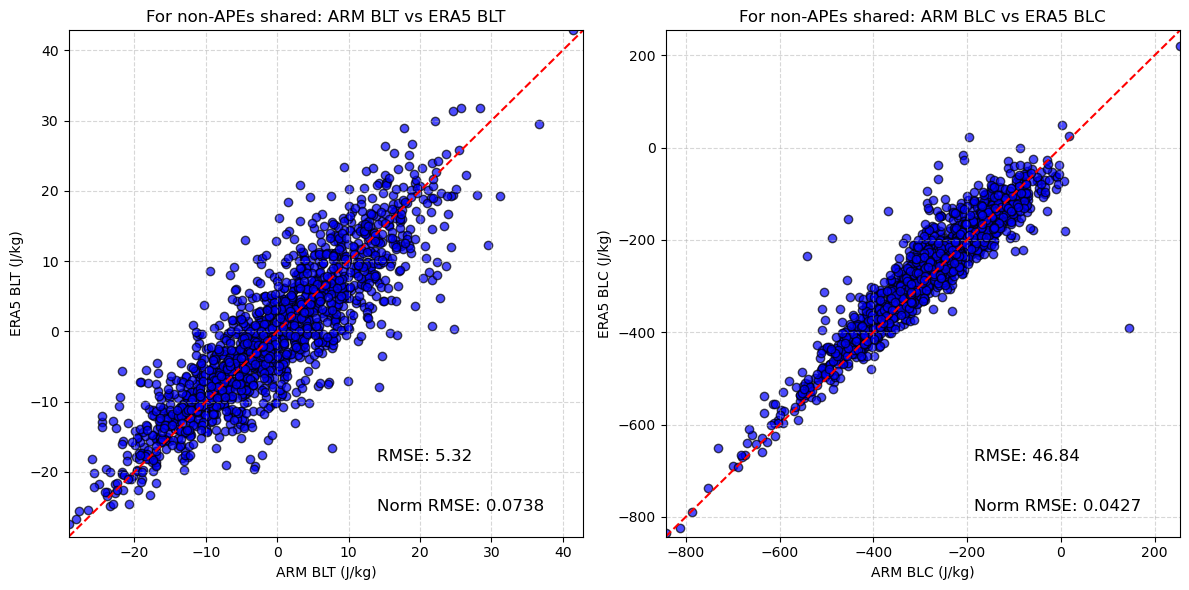

In [18]:
def plot_rmse_comparison(df, title_prefix):
    
    # Define the data
    x1 = df['arm_blt']
    
    y1 = df['era5_blt']
    
    x2 = df['arm_blc']
    
    y2 = df['era5_blc']

    # Calculate RMSE for both sets
    
    rmse_blt = np.sqrt(mean_squared_error(x1, y1))
    
    rmse_blc = np.sqrt(mean_squared_error(x2, y2))

    # Normalize RMSE using Min-Max Scaling
    rmse_blt_norm = rmse_blt / (max(x1.max(), y1.max()) - min(x1.min(), y1.min()))
    
    rmse_blc_norm = rmse_blc / (max(x2.max(), y2.max()) - min(x2.min(), y2.min()))

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for ARM BLT vs ERA5 BLT
    axes[0].scatter(x1, y1, alpha=0.7, edgecolor='k', label='Data Points', color='blue')
    axes[0].plot([min(x1.min(), y1.min()), max(x1.max(), y1.max())], 
                 [min(x1.min(), y1.min()), max(x1.max(), y1.max())], color='red', linestyle='--', label='1:1 Line')
    axes[0].set_xlabel('ARM BLT (J/kg)')
    axes[0].set_ylabel('ERA5 BLT (J/kg)')
    axes[0].set_title(f'{title_prefix} ARM BLT vs ERA5 BLT')
    axes[0].grid(True, linestyle='--', alpha=0.5)
    axes[0].set_xlim([min(x1.min(), y1.min()), max(x1.max(), y1.max())])
    axes[0].set_ylim([min(x1.min(), y1.min()), max(x1.max(), y1.max())])
    axes[0].text(0.6, 0.15, f'RMSE: {rmse_blt:.2f}', transform=axes[0].transAxes, fontsize=12, color='black')
    axes[0].text(0.6, 0.05, f'Norm RMSE: {rmse_blt_norm:.4f}', transform=axes[0].transAxes, fontsize=12, color='black')

    # Plot for ARM BLC vs ERA5 BLC
    axes[1].scatter(x2, y2, alpha=0.7, edgecolor='k', label='Data Points', color='blue')
    axes[1].plot([min(x2.min(), y2.min()), max(x2.max(), y2.max())], 
                 [min(x2.min(), y2.min()), max(x2.max(), y2.max())], color='red', linestyle='--', label='1:1 Line')
    axes[1].set_xlabel('ARM BLC (J/kg)')
    axes[1].set_ylabel('ERA5 BLC (J/kg)')
    axes[1].set_title(f'{title_prefix} ARM BLC vs ERA5 BLC')
    axes[1].grid(True, linestyle='--', alpha=0.5)
    axes[1].set_xlim([min(x2.min(), y2.min()), max(x2.max(), y2.max())])
    axes[1].set_ylim([min(x2.min(), y2.min()), max(x2.max(), y2.max())])
    axes[1].text(0.6, 0.15, f'RMSE: {rmse_blc:.2f}', transform=axes[1].transAxes, fontsize=12, color='black')
    axes[1].text(0.6, 0.05, f'Norm RMSE: {rmse_blc_norm:.4f}', transform=axes[1].transAxes, fontsize=12, color='black')

    # Make the layout tight
    plt.tight_layout()

    # Show the plot
    plt.show()

# Run for the first DataFrame 'shared_apes_result' with the title "For APEs shared"
plot_rmse_comparison(shared_nonapes_result, "For non-APEs shared:")

# # Run for the second DataFrame 'result_clean' with the title "For all days in time range:"
# plot_rmse_comparison(result_clean, "For all days in time range:")


In [19]:
# transforming all columns that contain lists into arrays and only extracting the first 4km of values
# for shared apes cases 

for col in shared_apes_result.columns:

    shared_apes_result[col] = shared_apes_result[col].apply(lambda x: np.array(x)[:201] if isinstance(x, (list, np.ndarray)) else x)

shared_apes_result['temp_diff'] = shared_apes_result.apply(lambda row: row['era5_interp_temp'] - row['arm_interp_temp'], axis=1)

shared_apes_result['q_diff'] = shared_apes_result.apply(lambda row: row['era5_q_obs'] - row['arm_q_obs'], axis=1)

average_temp_diff = np.mean(np.vstack(shared_apes_result['temp_diff']), axis=0)

median_temp_diff = np.median(np.vstack(shared_apes_result['temp_diff']), axis=0)

average_q_diff = np.mean(np.vstack(shared_apes_result['q_diff']), axis=0)

median_q_diff = np.median(np.vstack(shared_apes_result['q_diff']), axis=0)

p_era = shared_apes_result['era5_interp_pres'].iloc[0]


/tmp/ipykernel_68290/1848664745.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_apes_result[col] = shared_apes_result[col].apply(lambda x: np.array(x)[:201] if isinstance(x, (list, np.ndarray)) else x)
/tmp/ipykernel_68290/1848664745.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_apes_result['temp_diff'] = shared_apes_result.apply(lambda row: row['era5_interp_temp'] - row['arm_interp_temp'], axis=1)
/tmp/ipykernel_68290/1848664745.py:10: SettingWithCopyWarning: 
A value is trying to b

In [20]:
# transforming all columns that contain lists into arrays and only extracting the first 4km of values
# for shared non-apes cases 

for col in shared_nonapes_result.columns:

    shared_nonapes_result[col] = shared_nonapes_result[col].apply(lambda x: np.array(x)[:201] if isinstance(x, (list, np.ndarray)) else x)

shared_nonapes_result['temp_diff'] = shared_nonapes_result.apply(lambda row: row['era5_interp_temp'] - row['arm_interp_temp'], axis=1)

shared_nonapes_result['q_diff'] = shared_nonapes_result.apply(lambda row: row['era5_q_obs'] - row['arm_q_obs'], axis=1)

average_temp_diff = np.mean(np.vstack(shared_nonapes_result['temp_diff']), axis=0)

median_temp_diff = np.median(np.vstack(shared_nonapes_result['temp_diff']), axis=0)

average_q_diff = np.mean(np.vstack(shared_nonapes_result['q_diff']), axis=0)

median_q_diff = np.median(np.vstack(shared_nonapes_result['q_diff']), axis=0)

p_era = shared_nonapes_result['era5_interp_pres'].iloc[0]

/tmp/ipykernel_68290/2741860791.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_nonapes_result[col] = shared_nonapes_result[col].apply(lambda x: np.array(x)[:201] if isinstance(x, (list, np.ndarray)) else x)
/tmp/ipykernel_68290/2741860791.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_nonapes_result['temp_diff'] = shared_nonapes_result.apply(lambda row: row['era5_interp_temp'] - row['arm_interp_temp'], axis=1)
/tmp/ipykernel_68290/2741860791.py:10: SettingWithCopyWarning: 
A value is

In [21]:
# transforming all columns that contain lists into arrays and only extracting the first 4km of values

# for full time series 

for col in result_clean.columns:

    result_clean[col] = result_clean[col].apply(lambda x: np.array(x)[:201] if isinstance(x, (list, np.ndarray)) else x)

result_clean['temp_diff'] = result_clean.apply(lambda row: row['era5_interp_temp'] - row['arm_interp_temp'], axis=1)

result_clean['q_diff'] = result_clean.apply(lambda row: row['era5_q_obs'] - row['arm_q_obs'], axis=1)

average_temp_diff = np.mean(np.vstack(result_clean['temp_diff']), axis=0)

median_temp_diff = np.median(np.vstack(result_clean['temp_diff']), axis=0)

average_q_diff = np.mean(np.vstack(result_clean['q_diff']), axis=0)

median_q_diff = np.median(np.vstack(result_clean['q_diff']), axis=0)

p_era = result_clean['era5_interp_pres'].iloc[0]

/tmp/ipykernel_68290/1931868036.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_clean[col] = result_clean[col].apply(lambda x: np.array(x)[:201] if isinstance(x, (list, np.ndarray)) else x)
/tmp/ipykernel_68290/1931868036.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_clean['temp_diff'] = result_clean.apply(lambda row: row['era5_interp_temp'] - row['arm_interp_temp'], axis=1)
/tmp/ipykernel_68290/1931868036.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

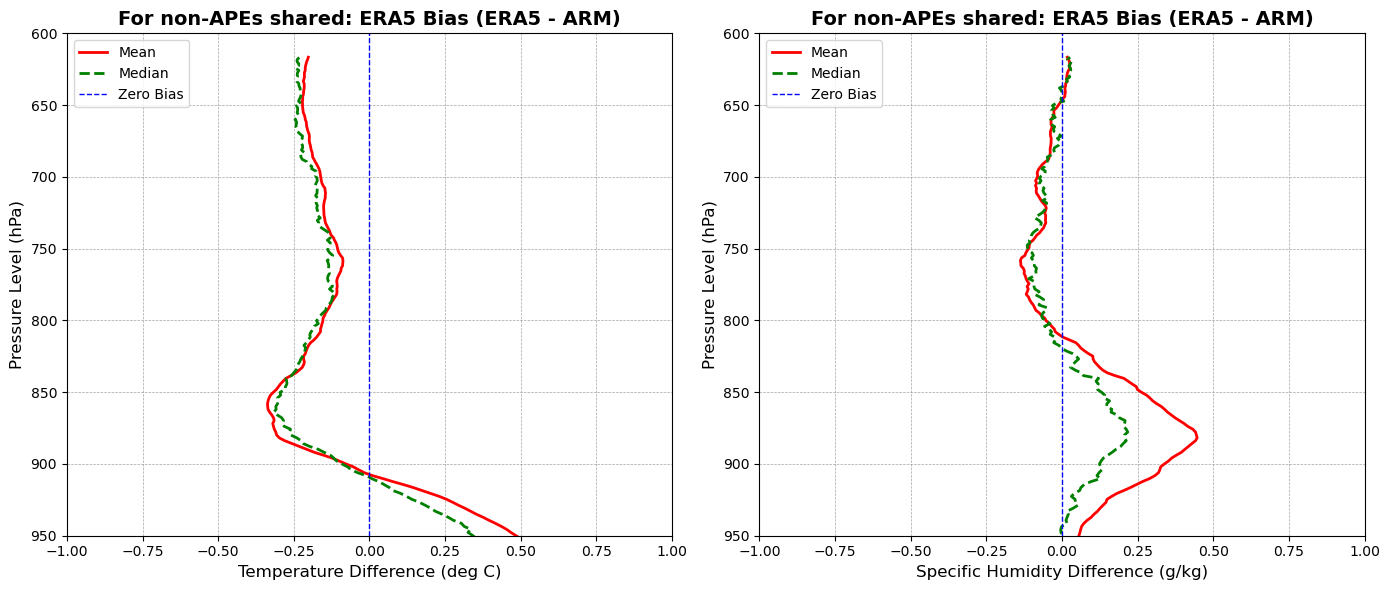

In [22]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the mean and median for temperature
axes[0].plot(average_temp_diff, p_era, color='red', label='Mean', linewidth=2)
axes[0].plot(median_temp_diff, p_era, color='green', label='Median', linestyle='--', linewidth=2)

# Zero bias reference line
axes[0].axvline(x=0, color='blue', linestyle='--', linewidth=1, label='Zero Bias')

# Add gridlines for better readability
axes[0].grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust x-axis and y-axis limits
axes[0].set_xlim(-1, 1)
axes[0].set_ylim(950, 600)

# Axis labels and title
axes[0].set_xlabel("Temperature Difference (deg C)", fontsize=12)
axes[0].set_ylabel("Pressure Level (hPa)", fontsize=12)
axes[0].set_title("For non-APEs shared: ERA5 Bias (ERA5 - ARM)", fontsize=14, fontweight='bold')

# Add a legend
axes[0].legend(loc='upper left', fontsize=10, frameon=True)

# Plotting the mean and median for specific humidity
axes[1].plot(average_q_diff, p_era, color='red', label='Mean', linewidth=2)
axes[1].plot(median_q_diff, p_era, color='green', label='Median', linestyle='--', linewidth=2)

# Zero bias reference line
axes[1].axvline(x=0, color='blue', linestyle='--', linewidth=1, label='Zero Bias')

# Add gridlines for better readability
axes[1].grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust x-axis and y-axis limits
axes[1].set_xlim(-1, 1)
axes[1].set_ylim(950, 600)

# Axis labels and title
axes[1].set_xlabel("Specific Humidity Difference (g/kg)", fontsize=12)
axes[1].set_ylabel("Pressure Level (hPa)", fontsize=12)
axes[1].set_title("For non-APEs shared: ERA5 Bias (ERA5 - ARM)", fontsize=14, fontweight='bold')

# Add a legend
axes[1].legend(loc='upper left', fontsize=10, frameon=True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the figure
plt.show()
